In [91]:
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True) 
# %matplotlib inline

In [92]:
tweets_raw_file   = 'Bitcoin_tweets.csv'
tweets_clean_file = 'Bitcoin_tweets_clean.csv'
bit_price_file2 = 'BTC-USD.csv'
# bit_price_file2 = 'data/BTC-USD.csv'

In [93]:
crypto_share_file = 'cryptos_share.xlsx'

In [94]:
df_crypto_share = pd.read_excel(crypto_share_file)
df_crypto_share

,Rank,Name (Symbol),Market Cap,Market Share,Price (USD),24 Hr % Change
0,1,Bitcoin (BTC),377831418959,0.426650,"$19,788.53580461",1.405399
1,2,Ethereum (ETH),131932928458,0.148979,"$1,085.4757985007",2.674509
2,3,Tether (USDT),65893735487,0.074408,$0.9994358555,0.013843
3,4,USD Coin (USDC),55341425347,0.062492,$1.0001902354,0.003141
4,5,BNB (BNB),37304145666,0.042124,$228.4715634316,2.255070
...,...,...,...,...,...,...
95,96,Synthetix (SNX),297134076,0.000336,$2.5873398571,11.800449
96,97,Kadena (KDA),287589868,0.000325,$1.556201613,3.230344
97,98,Gnosis (GNO),281937967,0.000318,$109.2957353512,3.299645
98,99,Symbol (XYM),279740886,0.000316,$0.0501106834,1.092375


In [95]:
df_crypto_share = df_crypto_share[:10]

In [96]:
df_crypto_share['Market Cap']

0    377831418959
1    131932928458
2     65893735487
3     55341425347
4     37304145666
5     17536765979
6     15197534762
7     14184448076
8     11725782047
9      7976183789
Name: Market Cap, dtype: int64

In [97]:
df_crypto_share.rename(columns={'Name (Symbol)': 'Name'}, inplace=True)

/var/folders/n9/5vzqc5vn059b3mb2j9ndtlth0000gn/T/ipykernel_1408/2754735262.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
df_crypto_share.columns

Index(['Rank', 'Name', 'Market Cap', 'Market Share', 'Price (USD)',
       '24 Hr % Change'],
      dtype='object')

In [99]:
fig = px.pie(df_crypto_share, values='Market Cap', names='Name')
fig.show()

In [100]:
px.bar(df_crypto_share, x='Name', y='Market Cap', title="Top 10 Crypto Market Data")

In [101]:
df_raw = pd.read_csv(tweets_raw_file,low_memory=False)
print(df_raw.shape)
df_raw.head(5)

(2259788, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [102]:
df_raw.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

In [103]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259788 entries, 0 to 2259787
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_name         object 
 1   user_location     object 
 2   user_description  object 
 3   user_created      object 
 4   user_followers    float64
 5   user_friends      object 
 6   user_favourites   object 
 7   user_verified     object 
 8   date              object 
 9   text              object 
 10  hashtags          object 
 11  source            object 
 12  is_retweet        object 
dtypes: float64(1), object(12)
memory usage: 224.1+ MB


In [104]:
df_raw.describe()

,user_followers
count,2.259650e+06
mean,8.654351e+03
std,1.099833e+05
min,0.000000e+00
25%,4.300000e+01
50%,2.010000e+02
75%,1.213000e+03
max,2.413135e+07


In [105]:
df_tt = pd.to_datetime(df_raw['date'], format='%Y-%m-%d %H:%M:%S', errors= 'coerce')
df_tt

0         2021-02-10 23:59:04
1         2021-02-10 23:58:48
2         2021-02-10 23:54:48
3         2021-02-10 23:54:33
4         2021-02-10 23:54:06
                  ...        
2259783   2022-01-19 19:08:16
2259784   2022-01-19 19:08:08
2259785   2022-01-19 19:08:02
2259786   2022-01-19 19:07:54
2259787   2022-01-19 19:07:52
Name: date, Length: 2259788, dtype: datetime64[ns]

In [106]:
df_tt.sort_values()

21523     2021-02-05 10:52:04
21524     2021-02-05 10:52:04
21522     2021-02-05 10:52:06
21521     2021-02-05 10:52:07
21520     2021-02-05 10:52:26
                  ...        
2254856                   NaT
2255544                   NaT
2255545                   NaT
2259246                   NaT
2259247                   NaT
Name: date, Length: 2259788, dtype: datetime64[ns]

In [107]:
df_tt.sort_values()[df_tt==None]

Series([], Name: date, dtype: datetime64[ns])

In [108]:
df_tt = df_tt[pd.notnull(df_tt)]

In [109]:
df_tt.sort_values().head(5)

21523   2021-02-05 10:52:04
21524   2021-02-05 10:52:04
21522   2021-02-05 10:52:06
21521   2021-02-05 10:52:07
21520   2021-02-05 10:52:26
Name: date, dtype: datetime64[ns]

In [110]:
df_tt.sort_values().tail()

2175868   2022-01-22 23:59:53
2126413   2022-01-22 23:59:54
2175867   2022-01-22 23:59:55
2126412   2022-01-22 23:59:57
2126411   2022-01-22 23:59:58
Name: date, dtype: datetime64[ns]

# Cleaning Data

In [111]:
# clean df 
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22598/22598 [00:01<00:00, 21761.95it/s]


In [112]:
dd.shape

(22598, 14)

In [113]:
dd[['text', 'date']]

,text,date
0,nice project \n\n\n\n\n\nortcoin ort okratech ...,2021-06-22 05:22:52
1,Long Bitcoin short the banks 🧐,2021-08-25 07:06:40
2,Top Trending Cryptocurrency Post - DOGECOIN Se...,2021-07-02 19:37:18
3,Can one expect another wave of BTC's decline s...,2021-07-24 14:14:53
4,We will see…\n\nbitcoin btc bnb band bake $btc...,2021-05-29 15:52:17
...,...,...
22593,Bitcoin is the American dream. Today I have fi...,2021-07-22 15:18:56
22594,"If you invested your $1,400.00 stimulus check ...",2021-08-23 22:00:04
22595,when glacier mining\n\n$btc Bitcoin,2021-06-21 09:09:22
22596,ANKR COIN will soon come to its new target of ...,2021-07-21 20:11:28


In [114]:
dd['text'].isnull().values.any()

False

In [115]:
dd.text.isnull().values.any()

False

In [116]:
dd.text.isnull().sum().sum()

0

In [117]:
for miss_dd in dd:
    print({miss_dd: dd[miss_dd].isnull().sum().sum()})

{'index': 0}
{'user_name': 0}
{'user_location': 11056}
{'user_description': 2705}
{'user_created': 1}
{'user_followers': 2}
{'user_friends': 2}
{'user_favourites': 2}
{'user_verified': 2}
{'date': 2}
{'text': 0}
{'hashtags': 178}
{'source': 33}
{'is_retweet': 4}


## Sentiment analysis tweets_clean_fileh Vader
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account

negations and contractions (not good, wasn’t good)
Punctuation (good!!!), CAPS, emotes :), emojis
Intensificators (very, kind of), acronyms ‘lol’
Scores between -1.0 (negative) and 1.0 (positive)

We will use this sentiment analysis of the tweets to calculate a score that will represent the importance of each tweet.

In [118]:
df_clean = pd.read_csv(tweets_clean_file)

In [119]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_clean['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22598/22598 [00:02<00:00, 10864.06it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,195760,محمد,esfahan,‏‏‏خودت رو به خودت ثابت کن،نه به دیگران,2021-01-02 19:08:56,616.0,1683.0,1712.0,False,2021-06-22 05:22:52,nice project \n\n\n\n\n\nortcoin ort okratech ...,"['ortcoin', 'ort', 'okratech', 'bitcoin', 'air...",Twitter for Android,False,0.5994
1,1135874,Crypto Revolution Merchandise 💚,NaN,Crypto Revolution the Wave of change 👊😎👊 Not y...,2019-10-13 06:16:05,451.0,2045.0,45077.0,False,2021-08-25 07:06:40,Long Bitcoin short the banks 🧐,['Bitcoin'],Twitter Web App,False,0.0000
2,332828,STRATO฿ITZ,USA,Digital Token Entrepreneur | Top Mod @ https:/...,2014-04-25 19:40:15,468.0,111.0,1262.0,False,2021-07-02 19:37:18,Top Trending Cryptocurrency Post - DOGECOIN Se...,"['Cryptocurrency', 'Bitcoin']",IFTTT,False,0.2023
3,581946,U.Today,"New York, USA",https://t.co/Tt6MRU7xb1 is an independent orga...,2018-01-17 09:28:59,35990.0,4447.0,682.0,False,2021-07-24 14:14:53,Can one expect another wave of BTC's decline s...,['BTC'],get shares,False,0.0000
4,108170,Mr Fulcanelli,Argentina,"be decentralized, be a smart contract",2010-08-23 20:41:38,164.0,100.0,9295.0,False,2021-05-29 15:52:17,We will see…\n\nbitcoin btc bnb band bake $btc...,"['bitcoin', 'btc', 'bnb', 'band', 'bake']",Twitter for Mac,False,0.0000


## Calculate a score for each tweet
To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.

The compound column represents the sentiment of the tweets and its value is between -1 and 1.

We also use the number of retweets, the number of likes, and the number of users that follow the tweet's author.

In [120]:
scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
df_clean["score"] = scores
df_clean.head(5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22598/22598 [00:00<00:00, 34138.68it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,195760,محمد,esfahan,‏‏‏خودت رو به خودت ثابت کن،نه به دیگران,2021-01-02 19:08:56,616.0,1683.0,1712.0,False,2021-06-22 05:22:52,nice project \n\n\n\n\n\nortcoin ort okratech ...,"['ortcoin', 'ort', 'okratech', 'bitcoin', 'air...",Twitter for Android,False,0.5994,1025.108064
1,1135874,Crypto Revolution Merchandise 💚,NaN,Crypto Revolution the Wave of change 👊😎👊 Not y...,2019-10-13 06:16:05,451.0,2045.0,45077.0,False,2021-08-25 07:06:40,Long Bitcoin short the banks 🧐,['Bitcoin'],Twitter Web App,False,0.0000,0.000000
2,332828,STRATO฿ITZ,USA,Digital Token Entrepreneur | Top Mod @ https:/...,2014-04-25 19:40:15,468.0,111.0,1262.0,False,2021-07-02 19:37:18,Top Trending Cryptocurrency Post - DOGECOIN Se...,"['Cryptocurrency', 'Bitcoin']",IFTTT,False,0.2023,254.960113
3,581946,U.Today,"New York, USA",https://t.co/Tt6MRU7xb1 is an independent orga...,2018-01-17 09:28:59,35990.0,4447.0,682.0,False,2021-07-24 14:14:53,Can one expect another wave of BTC's decline s...,['BTC'],get shares,False,0.0000,0.000000
4,108170,Mr Fulcanelli,Argentina,"be decentralized, be a smart contract",2010-08-23 20:41:38,164.0,100.0,9295.0,False,2021-05-29 15:52:17,We will see…\n\nbitcoin btc bnb band bake $btc...,"['bitcoin', 'btc', 'bnb', 'band', 'bake']",Twitter for Mac,False,0.0000,0.000000


## read Bitcoin price 

In [121]:
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)
# df_price.Timestamp = pd.to_datetime(df_price.Timestamp,unit='s')
df_price.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


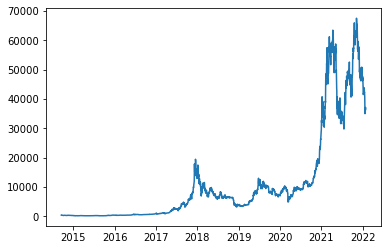

In [122]:
plt.plot(df_price['Date'], df_price['Close'])

In [123]:
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(
    go.Scatter(x=df_price.index, y=df_price["Close"], name="Price"), secondary_y=False
)
fig2.add_trace(go.Bar(x=df_price.index, y=df_price["High"], name="Positive"), secondary_y=True)
fig2.add_trace(go.Bar(x=df_price.index, y=df_price["Low"], name="Negative"), secondary_y=True)


# a few changes to make layout work better
#  1. put close at front
#  2. reduce "whitespace" in bars
fig2.update_layout(
    yaxis={"overlaying": "y2"}, yaxis2={"overlaying": None}, barmode="overlay", bargap=0
)

In [124]:
fig = go.Figure(data=go.Scatter(x=df_price['Date'].astype(dtype=str), 
                        y=df_price['Close'],
                        marker_color='indianred', text="counts"))
fig.update_layout({"title": 'Price',
                   "xaxis": {"title":"Year"},
                   "yaxis": {"title":"Close"},
                   "showlegend": False})
# fig.write_image("by-month.png",format="png", width=1000, height=600, scale=3)
fig.show()

In [125]:
top_dates = df_price.sort_values(by=['Close'],ascending=False).head(3)
vals = []
for tgl, tot in zip(top_dates["Date"], top_dates["Close"]):
    tgl = tgl.strftime("%d %B")
    val = "%d (%s)"%(tot, tgl)
    vals.append(val)
top_dates['tgl'] = vals
top_dates

,Date,Open,High,Low,Close,Adj Close,Volume,tgl
2609,2021-11-08,63344.066406,67673.742188,63344.066406,67566.828125,67566.828125,41125608330,67566 (08 November)
2610,2021-11-09,67549.734375,68530.335938,66382.062500,66971.828125,66971.828125,42357991721,66971 (09 November)
2590,2021-10-20,64284.585938,66930.390625,63610.675781,65992.835938,65992.835938,40788955582,65992 (20 October)


In [126]:
fig = go.Figure(data=go.Scatter(x=df_price['Date'].astype(dtype=str), 
                                y=df_price['Close'],
                                marker_color='black', text="counts"))
fig.update_layout({"title": 'Price from Jan 2015 to Jan 2022',
                   "xaxis": {"title":"Year"},
                   "yaxis": {"title":"Close"},
                   "showlegend": False})
fig.add_traces(go.Scatter(x=top_dates['Date'], y=top_dates['Close'],
                          textposition='top left',
                          textfont=dict(color='#233a77'),
                          mode='markers+text',
                          marker=dict(color='red', size=6),
                          text = top_dates["tgl"]))
fig.show()


# sentiment analysis 

In [127]:
df_clean = df_clean.drop_duplicates()
tweets = df_clean.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

# tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['score'].sum()
tweets_grouped = tweets.resample('1h').sum()

crypto_usd = df_price.copy()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']
# crypto_usd['Timestamp'] = pd.to_datetime(crypto_usd['Timestamp'], unit='s')
# crypto_usd.index = crypto_usd['Timestamp']

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()

In [128]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']
# xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, m ='pearson' ) for i in range(-20,20)]
# tweets_grouped.corrwith(crypto_usd_grouped,method='pearson')

In [129]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

In [130]:
# ax1.plot_date(pd.to_datetime(tweets_grouped.index), tweets_grouped, 'g-')
# tweets_grouped.index = pd.to_datetime(tweets_grouped.index)

In [131]:
tweets_grouped.columns

Index(['index', 'user_followers', 'user_friends', 'user_favourites',
       'compound', 'score'],
      dtype='object')

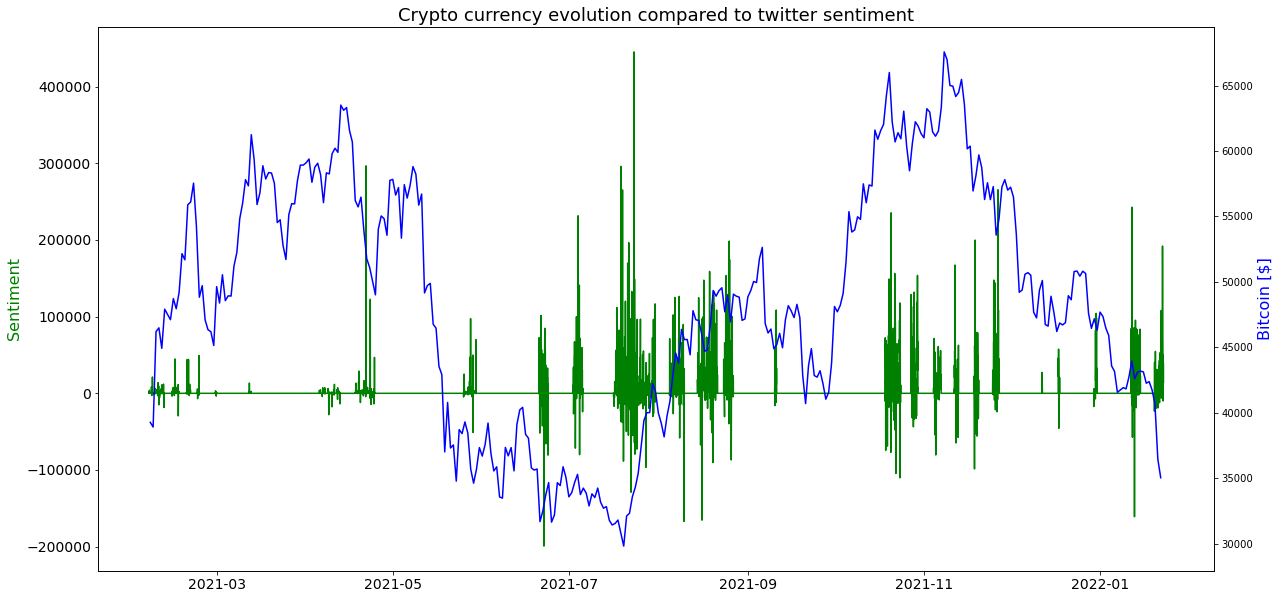

In [132]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index,  tweets_grouped['score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

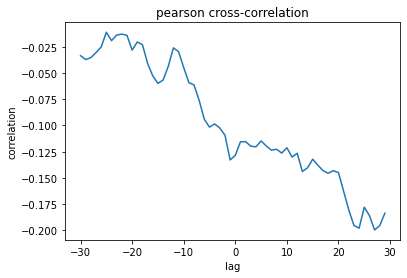

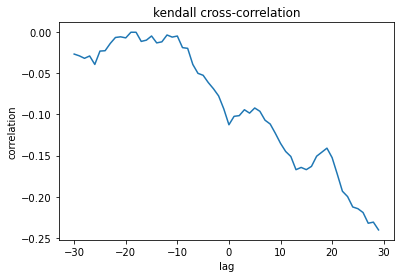

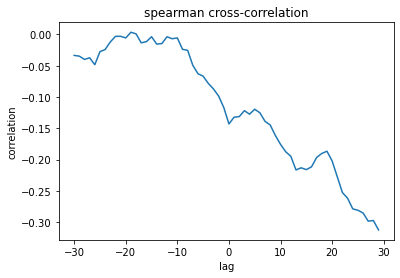

In [133]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-30,30)]
plt.plot(range(-30,30), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-30,30)]
plt.plot(range(-30,30), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-30,30)]
plt.plot(range(-30,30), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Normalization

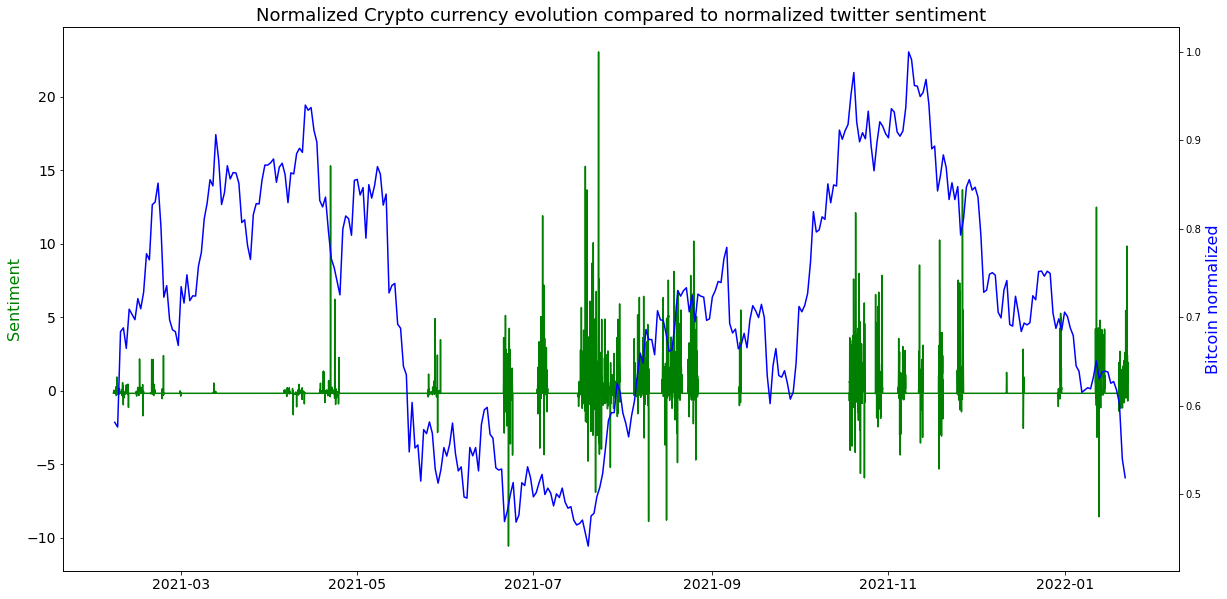

In [134]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

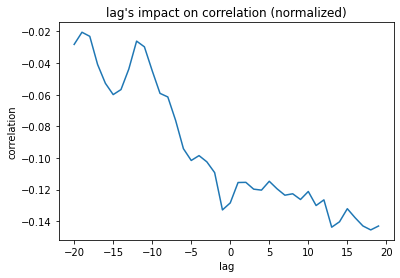

In [135]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Derivative of Crypto price 

In [136]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), 
                                      tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, 
                                          name='slope')

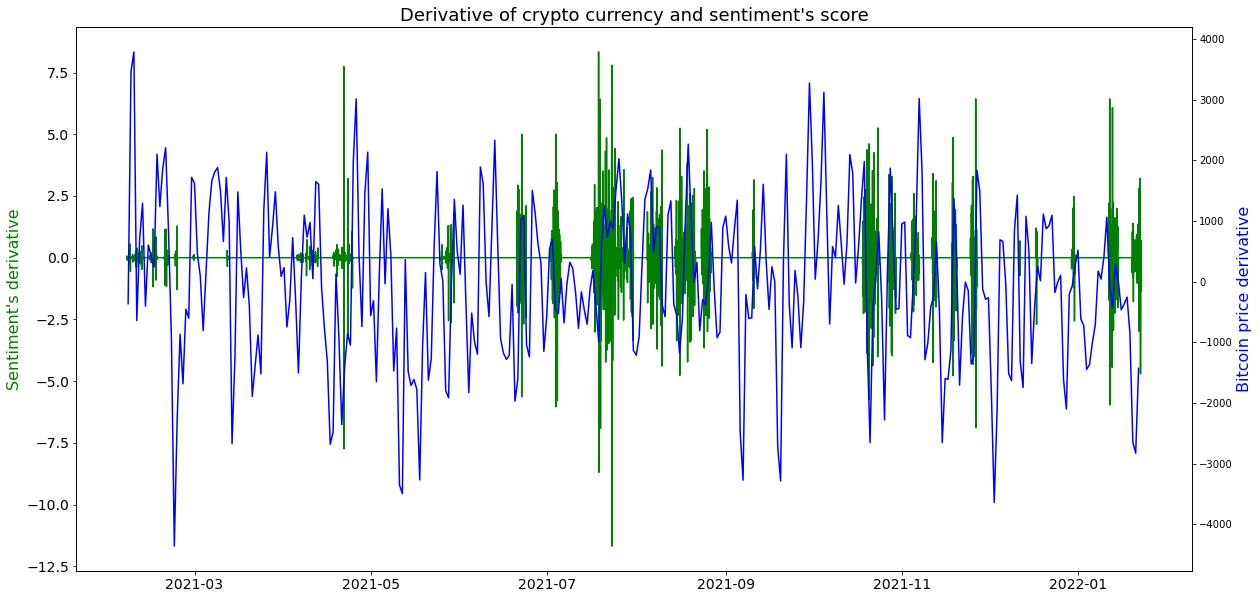

In [137]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

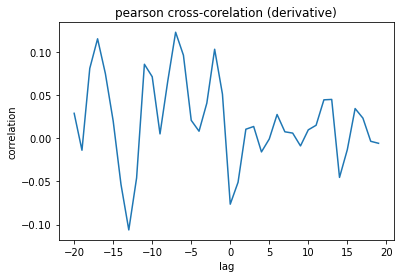

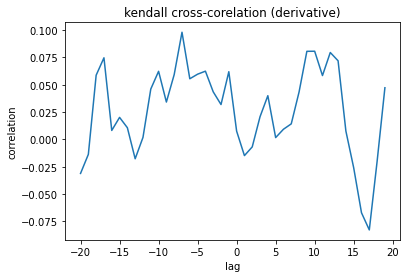

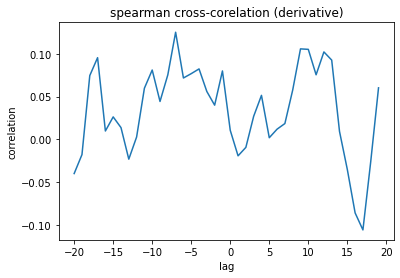

In [138]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

# Part 2 NLP Modeling 

In [139]:
# ! pip install textblob 
from textblob import TextBlob

df = df_clean.copy()
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']] 
df.columns = ['tweets']
df.head()

,tweets
0,nice project \n\n\n\n\n\nortcoin ort okratech ...
1,Long Bitcoin short the banks 🧐
2,Top Trending Cryptocurrency Post - DOGECOIN Se...
3,Can one expect another wave of BTC's decline s...
4,We will see…\n\nbitcoin btc bnb band bake $btc...


In [140]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package wordnet to /Users/mintu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mintu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mintu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [141]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [142]:
import nltk 
nltk.download('omw-1.4')
  

[nltk_data] Downloading package omw-1.4 to /Users/mintu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [143]:
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
df['date'] = df_clean['date']
df['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df.drop(columns='date',inplace=True)
df.head()

,tweets,cleaned_tweets,date_clean
0,nice project \n\n\n\n\n\nortcoin ort okratech ...,nice project ortcoin ort okratech bitcoin aird...,2021-06-22
1,Long Bitcoin short the banks 🧐,Long Bitcoin short bank,2021-08-25
2,Top Trending Cryptocurrency Post - DOGECOIN Se...,Top Trending Cryptocurrency Post DOGECOIN Sell...,2021-07-02
3,Can one expect another wave of BTC's decline s...,Can one expect another wave BTC decline soon v...,2021-07-24
4,We will see…\n\nbitcoin btc bnb band bake $btc...,We see bitcoin btc bnb band bake btc dCc xZ dP,2021-05-29


In [144]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [145]:
def crypto_price_cate(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'
    
def observe_period(period):
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    res = res.apply(crypto_price_cate)
    return res 

time_sentiment = observe_period(7) # compare price ratio in 7 days. price_7_days_later/ price_now 
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [146]:
# may takes time 
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,nice project \n\n\n\n\n\nortcoin ort okratech ...,nice project ortcoin ort okratech bitcoin aird...,2021-06-22,positive,1.00,0.600
1,Long Bitcoin short the banks 🧐,Long Bitcoin short bank,2021-08-25,negative,0.35,-0.025
2,Top Trending Cryptocurrency Post - DOGECOIN Se...,Top Trending Cryptocurrency Post DOGECOIN Sell...,2021-07-02,negative,0.40,0.250
3,Can one expect another wave of BTC's decline s...,Can one expect another wave BTC decline soon v...,2021-07-24,negative,0.00,0.000
4,We will see…\n\nbitcoin btc bnb band bake $btc...,We see bitcoin btc bnb band bake btc dCc xZ dP,2021-05-29,positive,0.00,0.000


In [147]:
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()
df.to_csv('./df_data.csv')

In [148]:
pd.read_csv('df_data.csv')

,Unnamed: 0,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,0,nice project \n\n\n\n\n\nortcoin ort okratech ...,nice project ortcoin ort okratech bitcoin aird...,2021-06-22,positive,1.000000,0.600000,positive,True
1,1,Long Bitcoin short the banks 🧐,Long Bitcoin short bank,2021-08-25,negative,0.350000,-0.025000,negative,True
2,2,Top Trending Cryptocurrency Post - DOGECOIN Se...,Top Trending Cryptocurrency Post DOGECOIN Sell...,2021-07-02,negative,0.400000,0.250000,positive,False
3,3,Can one expect another wave of BTC's decline s...,Can one expect another wave BTC decline soon v...,2021-07-24,negative,0.000000,0.000000,neutral,False
4,4,We will see…\n\nbitcoin btc bnb band bake $btc...,We see bitcoin btc bnb band bake btc dCc xZ dP,2021-05-29,positive,0.000000,0.000000,neutral,False
...,...,...,...,...,...,...,...,...,...
22415,22593,Bitcoin is the American dream. Today I have fi...,Bitcoin American dream Today I fired ASICs par...,2021-07-22,negative,0.000000,0.000000,neutral,False
22416,22594,"If you invested your $1,400.00 stimulus check ...",If invested stimulus check bitcoin investment ...,2021-08-23,negative,0.250000,0.150000,positive,False
22417,22595,when glacier mining\n\n$btc Bitcoin,glacier mining btc Bitcoin,2021-06-21,positive,0.000000,0.000000,neutral,False
22418,22596,ANKR COIN will soon come to its new target of ...,ANKR COIN soon come new target dollar likely d...,2021-07-21,positive,0.618182,0.312121,positive,True


## Model preparation 

In [149]:
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,nice project \n\n\n\n\n\nortcoin ort okratech ...,nice project ortcoin ort okratech bitcoin aird...,2021-06-22,positive,1.00,0.600,positive,True
1,Long Bitcoin short the banks 🧐,Long Bitcoin short bank,2021-08-25,negative,0.35,-0.025,negative,True
2,Top Trending Cryptocurrency Post - DOGECOIN Se...,Top Trending Cryptocurrency Post DOGECOIN Sell...,2021-07-02,negative,0.40,0.250,positive,False
3,Can one expect another wave of BTC's decline s...,Can one expect another wave BTC decline soon v...,2021-07-24,negative,0.00,0.000,neutral,False
4,We will see…\n\nbitcoin btc bnb band bake $btc...,We see bitcoin btc bnb band bake btc dCc xZ dP,2021-05-29,positive,0.00,0.000,neutral,False


In [150]:
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [151]:
seed = 38 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17936,) (4484,) (17936, 3) (4484, 3)


In [152]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [153]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(17936, 30) (4484, 30)


In [154]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

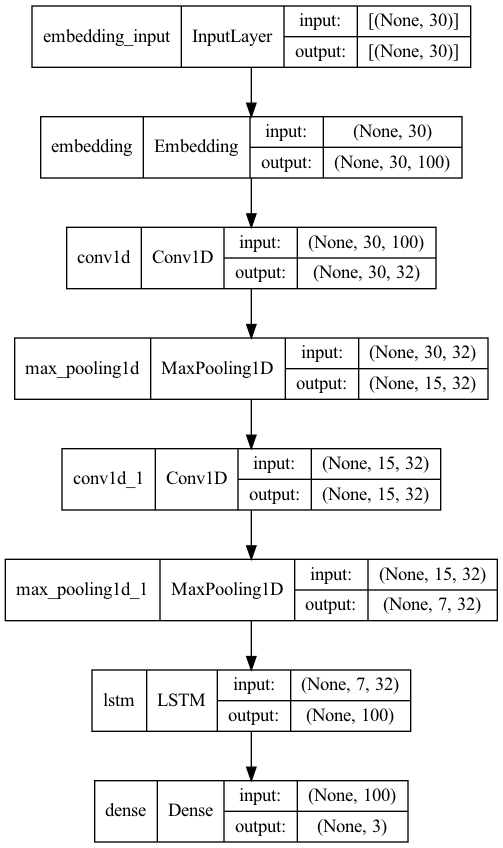

In [155]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [156]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
141/141 - 4s - loss: 0.6332 - accuracy: 0.7385 - val_loss: 0.3700 - val_accuracy: 0.8635 - 4s/epoch - 27ms/step
Epoch 2/10
141/141 - 2s - loss: 0.2463 - accuracy: 0.9153 - val_loss: 0.2533 - val_accuracy: 0.9190 - 2s/epoch - 16ms/step
Epoch 3/10
141/141 - 2s - loss: 0.0936 - accuracy: 0.9710 - val_loss: 0.2514 - val_accuracy: 0.9298 - 2s/epoch - 16ms/step
Epoch 4/10
141/141 - 2s - loss: 0.0401 - accuracy: 0.9894 - val_loss: 0.3151 - val_accuracy: 0.9244 - 2s/epoch - 16ms/step
Epoch 5/10
141/141 - 2s - loss: 0.0244 - accuracy: 0.9936 - val_loss: 0.2920 - val_accuracy: 0.9333 - 2s/epoch - 16ms/step
Epoch 6/10
141/141 - 2s - loss: 0.0155 - accuracy: 0.9958 - val_loss: 0.3322 - val_accuracy: 0.9213 - 2s/epoch - 16ms/step
Epoch 7/10
141/141 - 2s - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.3875 - val_accuracy: 0.9266 - 2s/epoch - 16ms/step
Epoch 8/10
141/141 - 2s - loss: 0.0089 - accuracy: 0.9979 - val_loss: 0.3467 - val_accuracy: 0.9269 - 2s/epoch - 16ms/step
Epoch 9/10
141/1

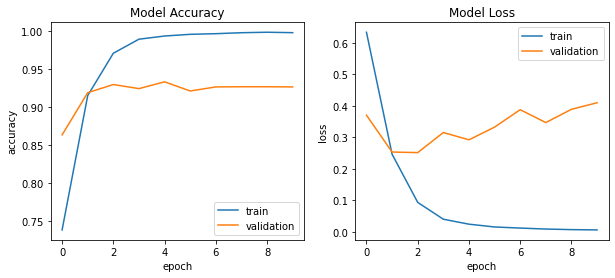

In [157]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [158]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test)

Accuracy:	92.7%
              precision    recall  f1-score   support

           0       0.87      0.67      0.76       478
           1       0.94      0.94      0.94      1782
           2       0.93      0.97      0.95      2224

    accuracy                           0.93      4484
   macro avg       0.91      0.86      0.88      4484
weighted avg       0.93      0.93      0.92      4484



2    2224
1    1782
0     478
dtype: int64
2    2320
1    1794
0     370
dtype: int64


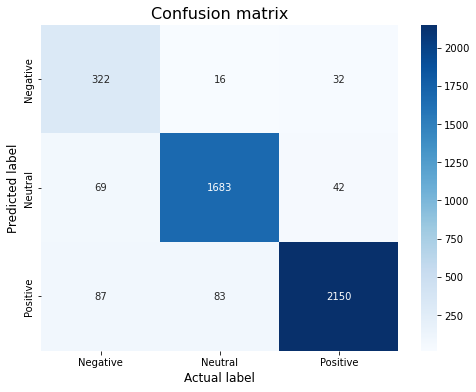

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Model2 

In [160]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleaned_tweets'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaned_tweets'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 nice project ortcoin ort okratech bitcoin airdrop freelancer crypto dRywbnSVCo
After Tokenization & Padding 
 [ 204    5 2119 1795 2120    1   11 1735    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [161]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (13452, 50) (13452, 3)
Validation Set:  (4484, 50) (4484, 3)
Test Set:  (4484, 50) (4484, 3)


In [162]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [163]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [164]:
vocab_size = 5000
embedding_size = 32
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

In [165]:
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [166]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


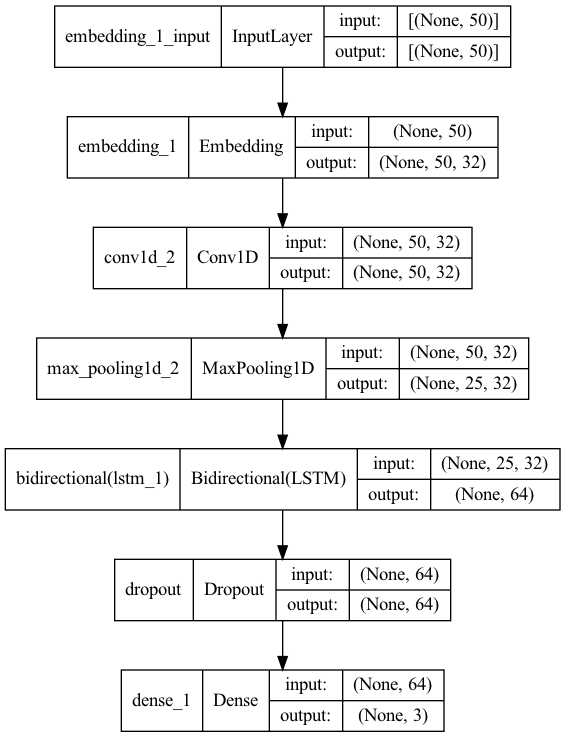

In [167]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [168]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [169]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/50
106/106 [==============================] - 6s 18ms/step - loss: 0.9824 - accuracy: 0.4910 - precision: 0.5007 - recall: 0.1098 - val_loss: 0.9579 - val_accuracy: 0.4931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
106/106 [==============================] - 1s 14ms/step - loss: 0.9519 - accuracy: 0.5005 - precision: 0.5239 - recall: 0.2426 - val_loss: 0.9540 - val_accuracy: 0.4931 - val_precision: 1.0000 - val_recall: 6.6905e-04
Epoch 3/50
106/106 [==============================] - 1s 13ms/step - loss: 0.9465 - accuracy: 0.5074 - precision: 0.5664 - recall: 0.2471 - val_loss: 0.9455 - val_accuracy: 0.4931 - val_precision: 0.5936 - val_recall: 0.3941
Epoch 4/50
106/106 [==============================] - 1s 13ms/step - loss: 0.9315 - accuracy: 0.5561 - precision: 0.6184 - recall: 0.2895 - val_loss: 0.9174 - val_accuracy: 0.5847 - val_precision: 0.6443 - val_recall: 0.3838
Epoch 5/50
106/106 [==============================] - 1s 13ms/step - loss: 0.8997 - accu

106/106 [==============================] - 1s 13ms/step - loss: 0.2808 - accuracy: 0.9031 - precision: 0.9242 - recall: 0.8762 - val_loss: 0.4264 - val_accuracy: 0.8604 - val_precision: 0.8757 - val_recall: 0.8439
Epoch 38/50
106/106 [==============================] - 1s 13ms/step - loss: 0.2718 - accuracy: 0.9083 - precision: 0.9283 - recall: 0.8811 - val_loss: 0.4066 - val_accuracy: 0.8666 - val_precision: 0.8925 - val_recall: 0.8426
Epoch 39/50
106/106 [==============================] - 1s 13ms/step - loss: 0.2711 - accuracy: 0.9056 - precision: 0.9274 - recall: 0.8801 - val_loss: 0.4609 - val_accuracy: 0.8343 - val_precision: 0.8676 - val_recall: 0.8111
Epoch 40/50
106/106 [==============================] - 1s 13ms/step - loss: 0.2585 - accuracy: 0.9157 - precision: 0.9323 - recall: 0.8898 - val_loss: 0.4113 - val_accuracy: 0.8700 - val_precision: 0.8882 - val_recall: 0.8486
Epoch 41/50
106/106 [==============================] - 1s 13ms/step - loss: 0.2549 - accuracy: 0.9182 - prec

In [170]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8793
Precision : 0.8907
Recall    : 0.8684
F1 Score  : 0.8794


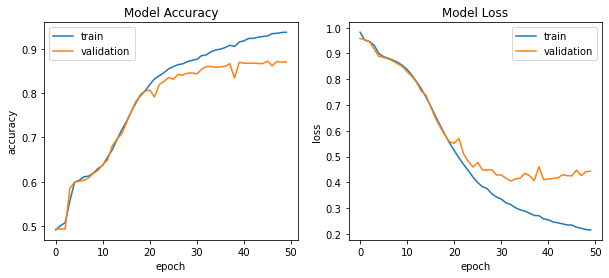

In [171]:
plot_training_hist(history)

2    2195
1    1833
0     456
dtype: int64
2    2303
1    1915
0     266
dtype: int64


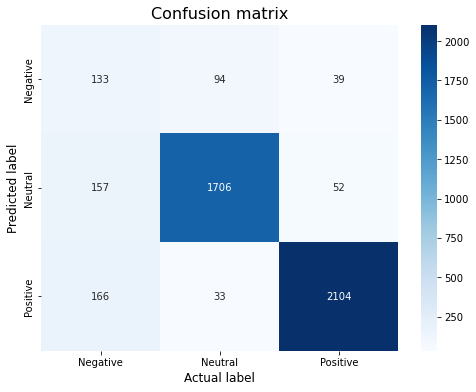

In [172]:
plot_confusion_matrix(model, X_test, y_test)